# 🧩 Análisis de redes con Python
**Workshop 4**

### *Creado por: Megan García Antivar* 🌱

En matemáticas y en ciencias de la computación, la teoría de grafos o análisis de redes estudia las propiedades de los grafos
(también llamadas gráficas). Un grafo es un conjunto, no vacío, de objetos llamados **vértices** (o nodos) y una selección de pares de vértices,
llamados aristas (edges en inglés) que pueden ser orientados o no. Típicamente, un grafo se representa mediante una serie de puntos (los vértices)
conectados por **líneas** (las aristas).

Tanto los nodos como las aristas pueden contener metadatos en forma de pares clave-valor. Por ejemplo, en una red social los nodos «Hugo» y “Eric” pueden tener cada uno un atributo {"edad 25 }, mientras que la arista entre ellos podría almacenar `{ «first_met»: «2016-05-21» }`.

**¿Por qué modelar los datos como un gráfo?** 🥸

Representar los datos como un grafo permite abordar cuestiones que son difíciles de responder con tablas convencionales, como:

- ¿Quiénes son las personas influyentes clave dentro de una comunidad en línea?
- ¿Cuál es la ruta óptima entre dos ciudades en una red de transporte?
- ¿Existen clusters o comunidades densamente conectadas en la red?
- Encontrar el camino más corto utilizando una red de calles específica es un problema SIG común que tiene muchas aplicaciones prácticas. Por ejemplo, la navegación, una de esas aplicaciones para las que se utilizan algoritmos de encaminamiento para encontrar la ruta óptima entre dos o más puntos.

Examinando la estructura de un grafo podemos calcular métricas a nivel de nodo (por ejemplo, la centralidad), identificar puentes críticos o detectar agrupaciones naturales de comunidades.

## 1. Obtener una red ruteable

El paquete NetworkX ofrece varias herramientas para analizar redes e implementa distintos algoritmos de encaminamiento, como el de Dijkstra o el A*. Ambos se utilizan habitualmente para encontrar los caminos más cortos a lo largo de las redes de transporte.

Para poder realizar análisis de redes es necesario, por supuesto, disponer de una red que se utilice para los análisis. El paquete OSMnx nos permite recuperar redes ruteables de OpenStreetMap para varios modos de transporte (a pie, en bicicleta y en coche). OSMnx también envuelve algunas de las funcionalidades de NetworkX de una manera conveniente para su uso en los datos de OpenStreetMap.

En la siguiente sección, usaremos OSMnx para encontrar el camino más corto entre dos puntos basado en caminos ciclables. Con sólo pequeñas modificaciones, podemos repetir el análisis para la red de calles peatonales.

In [35]:
# Descargar librería para trabajar OpenStreetMap

!pip install osmnx

### 📦 ¿Qué es `osmnx`?

`osmnx` es una biblioteca de Python muy potente que permite trabajar con datos geoespaciales y de redes urbanas usando OpenStreetMap. A continuación se resumen sus principales funcionalidades:

| Funcionalidad | Descripción |
|---------------|-------------|
| Descargar datos | Permite obtener redes de calles, caminos y otros elementos desde OpenStreetMap. |
| Convertir en grafos | Convierte los datos en grafos de `networkx` o en `GeoDataFrames` para análisis geoespacial. |
| Análisis de redes | Calcula rutas más cortas, medidas de centralidad, accesibilidad, conectividad, etc. |
| Visualización | Genera mapas y gráficos de la red, rutas, puntos de interés, etc. |
| Trabajar con lugares reales | Permite usar nombres de lugares (ej. "Bogotá", "Teusaquillo") o polígonos personalizados como entrada. |

### - Importar librerías 📚

In [36]:
import osmnx as ox
import geopandas as gpd

### 1.1. Del análisis de rutas en la localidad de Teusaquillo

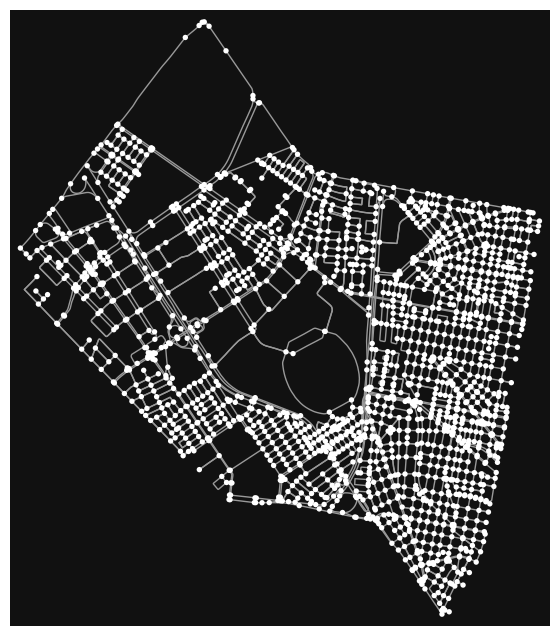

In [37]:
PLACE_NAME = "Teusaquillo, Bogotá, Colombia"
graph = ox.graph_from_place(
    PLACE_NAME,
    network_type="drive"
)
figure, ax = ox.plot_graph(graph)

### 📍 Expandir el área de análisis

A veces, las rutas más cortas pueden extenderse levemente más allá de los límites administrativos de un barrio. Para evitar rutas truncadas o sin conexión en los bordes de la red, es útil cargar un área más grande a partir de un punto central o buffer en relación al límite administrativo

<Axes: >

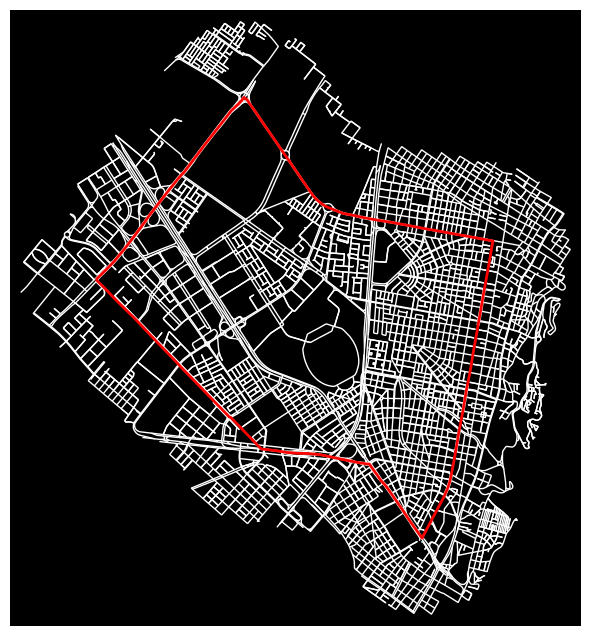

In [38]:
# Obtener el polígono de Teusaquillo
gdf = ox.geocode_to_gdf("Teusaquillo, Bogotá, Colombia")

# Proyectar para poder usar metros
gdf = gdf.to_crs(epsg=3857)

# Aplicar buffer (ej. 1000 metros)
gdf["geometry"] = gdf.buffer(1000)

# Volver a coordenadas geográficas
gdf = gdf.to_crs(epsg=4326)

# Descargar la red expandida con forma de la localidad + buffer
graph = ox.graph_from_polygon(gdf.geometry[0], network_type="drive")

# Visualizar
fig, ax = ox.plot_graph(graph, show=False, close=False, node_size=0.5, edge_color="white", bgcolor="black")
ox.geocode_to_gdf("Teusaquillo, Bogotá, Colombia").plot(ax=ax, facecolor="none", edgecolor="red", linewidth=2)